In [1]:
%matplotlib inline


<div class="alert alert-block alert-info">
<b>Credits:</b> This is a modified example from SimPEG.xyz </div>

# Linear Least-Squares Inversion

Here we demonstrate the basics of inverting data with SimPEG by considering a
linear inverse problem. We formulate the inverse problem as a least-squares
optimization problem. For this tutorial, we focus on the following:

    - Defining the forward problem
    - Defining the inverse problem (data misfit, regularization, optimization)
    - Specifying directives for the inversion
    - Recovering a set of model parameters which explains the observations


## Import Modules




In [2]:
import matplotlib.pyplot as plt
import numpy as np
from SimPEG import (
    simulation,
    maps,
    data_misfit,
    directives,
    optimization,
    inverse_problem,
    inversion,
)
from discretize import TensorMesh

from wbi import wavelet_regularization as regularization
# sphinx_gallery_thumbnail_number = 3

## Defining the Model and Mapping

Here we generate a synthetic model and a mappig which goes from the model
space to the row space of our linear operator.




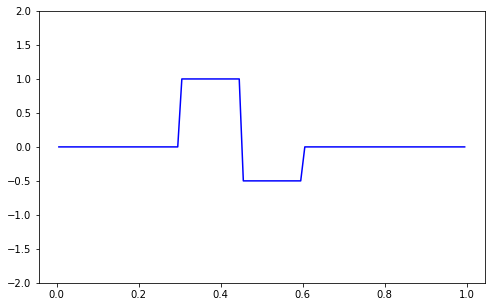

In [3]:
nParam = 100  # Number of model parameters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

# Mapping from the model space to the row space of the linear operator
model_map = maps.IdentityMap(mesh)

# Plotting the true model
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(mesh.vectorCCx, true_model, "b-")
ax.set_ylim([-2, 2])
plt.show()

## Defining the Linear Operator

Here we define the linear operator with dimensions (nData, nParam). In practive,
you may have a problem-specific linear operator which you would like to construct
or load here.




Text(0.5, 1.0, 'Columns of matrix G')

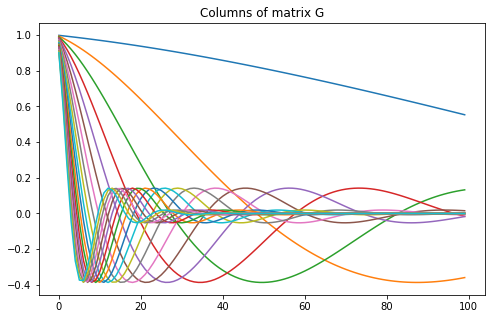

In [4]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial. The columns of the linear operator
# represents a set of decaying and oscillating functions.
jk = np.linspace(1.0, 60.0, nData)
p = -0.25
q = 0.25


def g(k):
    return np.exp(p * jk[k] * mesh.vectorCCx) * np.cos(
        np.pi * q * jk[k] * mesh.vectorCCx
    )


G = np.empty((nData, nParam))

for i in range(nData):
    G[i, :] = g(i)

# Plot the columns of G
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(G.shape[0]):
    ax.plot(G[i, :])

ax.set_title("Columns of matrix G")

## Defining the Simulation

The simulation defines the relationship between the model parameters and
predicted data.




In [5]:
sim = simulation.LinearSimulation(mesh, G=G, model_map=model_map)

/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/SimPEG/simulation.py:546: UserWarning: G has not been implemented for the simulation
  warnings.warn("G has not been implemented for the simulation")


## Predict Synthetic Data

Here, we use the true model to create synthetic data which we will subsequently
invert.




In [6]:
# Standard deviation of Gaussian noise being added
std = 0.01
np.random.seed(1)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, relative_error=std, add_noise=True)


## Define the Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem




In [7]:
#
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.


dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_obj)

# Define the regularization (model objective function).

# Play here with the wav-parameter
# - db1 = blocky
# - db2, db3, db4 = rather sharp
# - db5+ = rather smooth

reg = regularization.WaveletRegularization1D(mesh, wav="db6")

# Define how the optimization problem is solved.
opt = optimization.InexactGaussNewton(maxIter=100, maxIterLS=20)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Here we define any directiveas that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [target_misfit]


## Setting a Starting Model and Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [8]:
inv = inversion.BaseInversion(inv_prob)

# Starting model
starting_model = np.random.rand(nParam)
starting_model = np.zeros(nParam)


# The inversion class is kinda broken
# Run inversion
recovered_model = inv.run(starting_model)


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.00e+05  9.58e-03  1.00e+05    1.26e+06      0              
   1  1.00e+00  6.29e+04  2.00e-02  6.29e+04    7.20e+04      0              
   2  1.00e+00  2.93e+04  7.57e-02  2.93e+04    3.31e+04      0              
   3  1.00e+00  1.87e+04  8.19e-02  1.87e+04    1.58e+05      0              


/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   4  1.00e+00  1.59e+04  7.59e-02  1.59e+04    2.10e+04      0              
   5  1.00e+00  1.49e+04  7.74e-02  1.49e+04    9.11e+04      0              
   6  1.00e+00  1.44e+04  7.47e-02  1.44e+04    5.25e+04      0              
   7  1.00e+00  1.38e+04  7.31e-02  1.38e+04    1.01e+05      0              
   8  1.00e+00  6.57e+03  5.14e-02  6.57e+03    2.21e+04      0   Skip BFGS  
   9  1.00e+00  4.96e+03  5.28e-02  4.96e+03    2.22e+04      0              
  10  1.00e+00  4.36e+03  5.42e-02  4.36e+03    6.78e+04      0              
  11  1.00e+00  3.51e+03  5.26e-02  3.51e+03    4.76e+04      0              
  12  1.00e+00  3.07e+03  5.49e-02  3.07e+03    3.62e+04      0              
  13  1.00e+00  2.41e+03  5.43e-02  2.41e+03    2.48e+04      0              
  14  1.00e+00  1.55e+03  4.81e-02  1.55e+03    3.26e+04      0   Skip BFGS  
  15  1.00e+00  1.41e+03  4.74e-02  1.41e+03    1.96e+04      0              
  16  1.00e+00  9.10e+02  4.71e-02  9.10e+02    8.26e+04      0 

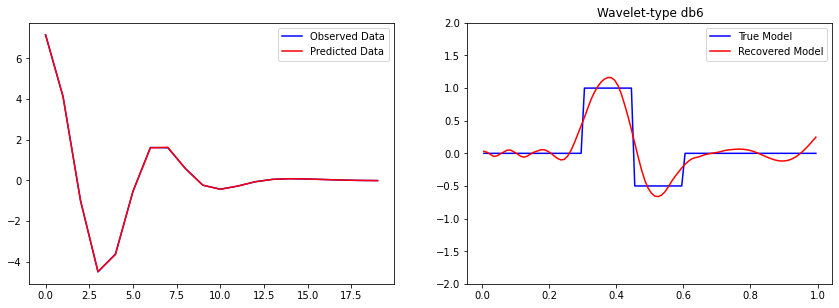

In [9]:
# Observed versus predicted data
fig, ax = plt.subplots(1, 2, figsize=(12 * 1.2, 4 * 1.2))
ax[0].plot(data_obj.dobs, "b-")
ax[0].plot(inv_prob.dpred, "r-")
ax[0].legend(("Observed Data", "Predicted Data"))

# True versus recovered model
ax[1].plot(mesh.vectorCCx, true_model, "b-")
ax[1].plot(mesh.vectorCCx, recovered_model, "r-")
ax[1].legend(("True Model", "Recovered Model"))
ax[1].set_ylim([-2, 2])
ax[1].set_title("Wavelet-type " + reg.wavelets.wav)

plt.show()

## Generate ensemble of inversion results

In [ ]:
fig, ax_ls = plt.subplots(2,3, figsize=(12, 6))
wav_list = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6']
betalist = [1e3, 1e4, 1e4, 1e4, 1e4, 1e4]
for idx, wav in enumerate(wav_list):
    reg = regularization.WaveletRegularization1D(mesh, wav=wav)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    inv_prob.beta = betalist[idx]
    inv = inversion.BaseInversion(inv_prob, directives_list)

    recovered_model = inv.run(starting_model)

    ax_ls[idx//3, idx%3].plot(mesh.vectorCCx, true_model, "b-")
    ax_ls[idx//3, idx%3].plot(mesh.vectorCCx, recovered_model, "r-")
    ax_ls[idx//3, idx%3].legend(("True Model", "Recovered Model"))
    # ax[1].set_ylim([-2, 2])
    ax_ls[idx//3, idx%3].set_title("Wavelet-type " + reg.wavelets.wav)
plt.tight_layout()
plt.show()